*To run cells with code, `shift + enter`* 

*To restart the session, `Kernel -> Restart and clear output`*

*To run all cells, `Cell -> Run all`*

# C$\alpha$ - C$\alpha$ distance Kullback-Leibler (KL) divergence
----

----
## Introduction 

-------




### <span style="color:DarkRed"> Some details on trajectory/topology input
    


-------

#### Topology format

For this tutorial, we will load the trajectory as a .dcd file, using a pdb as the topology. 

*Rename chain ID*

If the system has multiple chains, the script will only compute distances *within* each chain if the chain IDs are different (e.g. Chain A, Chain B, Chain C):

We need to rename all the chains with the same chain ID, which we can do with pymol. 

*Renumber residues*

It is also useful to ensure the residues are all numbered differently. For example you might have: 

* Chain A: residues 1-100


* Chain B: residues 1-100


* Chain C: residues 1-100


**Instead we want the labels to look like: **

* Chain A: residues 1-300


----

To chain chain ID: 

**Script to do below steps:**   `Scripts/Alter_chain_id.pml`

Open pymol and set retain_order and pdb_retain_ids: 

**`PyMOL>set retain_order, 1`**

**`PyMOL>set pdb_retain_ids, 1`**

then: 

**`PyMOL>alter all, chain='A'`**

Then save a pdb. 

-----

To renumber chain: 

Can use pymol script to [renumber](https://raw.githubusercontent.com/Pymol-Scripts/Pymol-script-repo/master/renumber.py) residues: `Scripts/renumber.py`

Open pymol and run the script. Then:

**`PyMOL>renumber chain A, 1`**

`Renumber: range (1 to 200)`
    



---

---

### <span style="color:DarkRed"> Input residues
    
---

Usually start with input all residues and find overall largest KL differences. 

Can also select particular regions - so a particular pocket, interface, etc - and only calculate pairs of distances involving those resiudes. 

C$\alpha$ distances are computed with mdtraj **[compute contacts](http://mdtraj.org/1.9.0/api/generated/mdtraj.compute_contacts.html)**:

>Parameters:	

>traj : md.Trajectory

>     An mdtraj trajectory. It must contain topology information.

>    contacts : array-like, ndim=2 or ‘all’

>     An array containing pairs of indices (0-indexed) of residues to compute the contacts between, or ‘all’. The string ‘all’ will select all pairs of residues separated by two or more residues (i.e. the i to i+1 and i to i+2 pairs will be excluded).


>> the itertools library can be useful to generate the arrays of indices (construct two groups of indices with atom selection):

>> `group_1 = [0, 1, 2]`

>> `group_2 = [10, 11]`

>> `pairs = list(itertools.product(group_1, group_2))`

>> `print(pairs)`

>> `[(0, 10), (0, 11), (1, 10), (1, 11), (2, 10), (2, 11)]`

>> `md.compute_contacts(t, pairs)`



# <span style="color:DarkRed"> Overall workflow

-----------

To summarise the overall workflow:

* 1: Run simulations. Process trajectory as detailed above.


* 2: Calculate all CA - CA distances for 2 or more systems. Output files with minimum and maximum distances for each CA - CA.


* 3: Determine overall min/max for each distance in order to set bin ranges for histograms.


* 4: Compute distributions for each distance.


* 5: Compute KL between the different systems. 


* 6: Plot the highest KL distances onto the structure in pymol, colour coded to show the range of KL. 

-------

# <span style="color:teal"> Step 1 of the workflow: </span>

--------

The folders for the simulation data are the same as those used for the previous analysis.

We will use the same two systems as the dihedral KL: `0_system_A` and `1_system_B`. 

In each of these folders, the trajectory `short_traj_aligned.dcd` will be used, and loaded with the topology `first_frame.pdb`.

In [1]:
# coding: utf-8
import numpy as np
get_ipython().magic(u'pylab inline')

Populating the interactive namespace from numpy and matplotlib


-------

# <span style="color:teal"> Step 2 of the workflow: </span>

--------

First, we need to calculate all CA distances to determine the minimum and maximum values for each distance. 

For a protein of **285** amino acids, we will calculate **39,903** distances. Since these distances will vary considerably, we cannot use the same bin range for everything. 

However for the KL calculation, we need to have the same bin range for a particular distance for each system. 

So first, we calculate the bin ranges for each system. 


- **Input system**

Select the system to run using `input_system`.

`input_system` is a list at the start of the script `9A_CA_contact_bin_range.py`. 

It just contains the names of the folders for the different systems:

`system_list = ["0_system_A","1_system_B"]`

Select using the index of the list (0 for the first entry in the list, 1 for the second).

- **Number of bins **

The number of bins will depend on the number of snapshots used. 

For a simulation of 1 $\mu$s, usually we save around 200k snapshots. Around 300 bins is appropriate for this number of datapoints. 

In this example, we have 4000 snapshots and so 60 bins are used.

### Run the script for the first system:

Run as `$ python 19_CA_CA_distances.py *input_system*`

To run from the notebook, execute the cell below with `shift + enter`:

In [2]:
!python Scripts/9A_CA_contact_bin_range.py 0

All input files:  [['0_TRAJECTORIES/0_system_A/short_traj_aligned.dcd'], ['0_TRAJECTORIES/1_system_B/short_traj_aligned.dcd']]
Trajectory input:  0_TRAJECTORIES/0_system_A/short_traj_aligned.dcd
Topology input:  0_TRAJECTORIES/0_system_A/first_frame.pdb
<mdtraj.Topology with 1 chains, 285 residues, 4676 atoms, 4717 bonds>
<mdtraj.Trajectory with 4000 frames, 4676 atoms, 285 residues, and unitcells>

Computing CA contacts...

Saved atom pairs to 4_CA_DISTANCES/0_system_A/OUTPUT/ALL_atom_pairs.dat

Saved min max values to 4_CA_DISTANCES/0_system_A/OUTPUT/min_max_rawdata.dat

Saved atom indices to 4_CA_DISTANCES/0_system_A/OUTPUT/atom_pairs_ATOM_NUMBERS.dat


### Compute the same for the second system: 

In [3]:
!python Scripts/9A_CA_contact_bin_range.py 1

All input files:  [['0_TRAJECTORIES/0_system_A/short_traj_aligned.dcd'], ['0_TRAJECTORIES/1_system_B/short_traj_aligned.dcd']]
Trajectory input:  0_TRAJECTORIES/1_system_B/short_traj_aligned.dcd
Topology input:  0_TRAJECTORIES/1_system_B/first_frame.pdb
<mdtraj.Topology with 1 chains, 285 residues, 4676 atoms, 4717 bonds>
<mdtraj.Trajectory with 4000 frames, 4676 atoms, 285 residues, and unitcells>

Computing CA contacts...

Saved atom pairs to 4_CA_DISTANCES/1_system_B/OUTPUT/ALL_atom_pairs.dat

Saved min max values to 4_CA_DISTANCES/1_system_B/OUTPUT/min_max_rawdata.dat

Saved atom indices to 4_CA_DISTANCES/1_system_B/OUTPUT/atom_pairs_ATOM_NUMBERS.dat


-------

# <span style="color:teal"> Step 3 of the workflow: </span>

--------

### Overall min and max for each distance for both systems

The script above calculated the minimum and maximum values for each C$\alpha$ - C$\alpha$ distance, for both systems. To find the overall max and min for both systems (to allow histograms for both to be binned with the same range) run the following script as:

`$ python *script*  *System_A_output_file_location*  *System_B_output_file_location*`

In [4]:
!python Scripts/9B_global_bin_range.py 4_CA_DISTANCES/0_system_A/OUTPUT 4_CA_DISTANCES/1_system_B/OUTPUT 

Loading min max values from 4_CA_DISTANCES/0_system_A/OUTPUT and 4_CA_DISTANCES/1_system_B/OUTPUT

Calculating overall min and max for each CA-CA distance... 

Saving overall min max to 4_CA_DISTANCES/global_min_max_array.dat


-------

# <span style="color:teal"> Step 4 of the workflow: </span>

--------

### Compute histograms

Now that we have the bin range that we can use for all systems, we can run for each again and output a histogram for each distance: 

In [5]:
!python Scripts/9C_CA_contact_compute_histograms.py 0

Trajectory input:  0_TRAJECTORIES/0_system_A/short_traj_aligned.dcd
Topology input:  0_TRAJECTORIES/0_system_A/first_frame.pdb

Computing CA contacts...

Loading min max values from 4_CA_DISTANCES/global_min_max_array.dat
Min bin : [5. 8. 7. ... 2. 2. 2.]
Max bin : [12. 16. 16. ... 12. 16. 12.]
Distribution data saved to 4_CA_DISTANCES/0_system_A/OUTPUT/CA_dist


In [6]:
!python Scripts/9C_CA_contact_compute_histograms.py 1

Trajectory input:  0_TRAJECTORIES/1_system_B/short_traj_aligned.dcd
Topology input:  0_TRAJECTORIES/1_system_B/first_frame.pdb

Computing CA contacts...

Loading min max values from 4_CA_DISTANCES/global_min_max_array.dat
Min bin : [5. 8. 7. ... 2. 2. 2.]
Max bin : [12. 16. 16. ... 12. 16. 12.]
Distribution data saved to 4_CA_DISTANCES/1_system_B/OUTPUT/CA_dist


-------

# <span style="color:teal"> Step 5 of the workflow: </span>

--------

### Calculating KL between two systems 

Once we have run the script above for the two different systems, we can do the KL calculation. 

In the folders `4_CA_DISTANCES/0_system_A/OUTPUT/CA_dist` and `4_CA_DISTANCES/1_system_B/OUTPUT/CA_dist`  we have a distribution for every CA distance for each system. 

We should also have files `4_CA_DISTANCES/0_system_A/OUTPUT/ALL_atom_pairs.dat` and `4_CA_DISTANCES/1_system_B/OUTPUT/ALL_atom_pairs.dat` which have the atom indices for each system's output.

#### Check that the output for each system has the same atom indices:

`$ vimdiff 4_CA_DISTANCES/0_system_A/OUTPUT/ALL_atom_pairs.dat 4_CA_DISTANCES/1_system_B/OUTPUT/ALL_atom_pairs.dat`

----------

In the folder `Scripts`, there is a script `9D_CA_KL_compute.py`. 

Run this, with the filepath to each system, and number of distances as arguments.

Move to the directory with the output data:

In [7]:
cd 4_CA_DISTANCES/

/home/t702348/lisa/X_PDK1_tutorial/0_Analysis/4_CA_DISTANCES


In [8]:
number_distances = np.loadtxt("ALL_atom_pairs.dat")
print ("Number of distances for this system : ") , (len(number_distances))

Number of distances for this system :  39903


In [9]:
!python ../Scripts/9D_CA_KL_compute.py 0_system_A/OUTPUT/CA_dist 1_system_B/OUTPUT/CA_dist 39903

### Make a file with atom indices and KL values for each distance: 

First check that all the atom pairs for each system are the same. Use vimdiff: 

`$ vimdiff 0_system_A/OUTPUT/ALL_atom_pairs.dat 1_system_B/OUTPUT/ALL_atom_pairs.dat`

And check the files with the atom numbers are the same: 

`$ vimdiff 0_system_A/OUTPUT/atom_pairs_ATOM_NUMBERS.dat 1_system_B/OUTPUT/atom_pairs_ATOM_NUMBERS.dat`

### As files for each system are the same, copy files to the folder 4_CA_DISTANCES:

In [10]:
cp 0_system_A/OUTPUT/ALL_atom_pairs.dat .

In [11]:
cp 0_system_A/OUTPUT/atom_pairs_ATOM_NUMBERS.dat .

In [12]:
!python ../Scripts/9E.CA_collect_KL.py


[[2.00000000e+00 7.00000000e+01 3.01790398e-02]
 [2.00000000e+00 1.02000000e+02 2.23366364e-02]
 [2.00000000e+00 1.08000000e+02 4.78831837e-02]
 ...
 [4.60300000e+03 4.64500000e+03 3.71725465e-01]
 [4.60300000e+03 4.66400000e+03 6.75851239e-01]
 [4.61700000e+03 4.66400000e+03 4.20544798e-01]]
[15.14658095]
[0.00192983]


In [ ]:
#atom_number_pair_array = np.loadtxt("atom_pairs_ATOM_NUMBERS.dat")
#print atom_number_pair_array.shape

In [ ]:
#KL_values = np.loadtxt("KL_OUTPUT/0_system_A_1_system_B/ALL_KL_CA.dat")
#print KL_values.shape

### Sizes of KL values

In order to set minimum limits of KL values in order to visualise, the below plot shows the KL for each distance in order to see where a lot of the values lie. 

Therefore we will use a lower cutoff od around 13 in order to only visualise the high KL distances. 

15.1465809545
0.0019298307


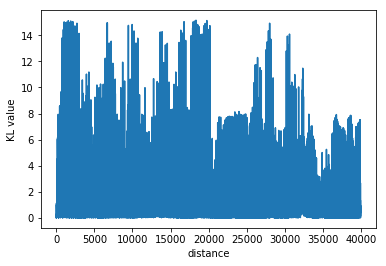

In [13]:
KLs = np.loadtxt("KL_OUTPUT/0A_1B_atoms_indices_KLs.dat")
plt.plot(KLs[:,2])
plt.xlabel("distance")
plt.ylabel("KL value")
print max(KLs[:,2])
print min(KLs[:,2])

-------

# <span style="color:teal"> Step 6 of the workflow: </span>

--------


### Visualising the output of the KL calculation 



From the above cell we can see the range of KL values for each of the distances. We need to select a cutoff for a minimum value, since we computed 39,903 distances - it won't be possible to visualise them all! 

In this case, a minimum KL of 14 has been selected. 

Since only a shortened trajectory was used for the tutorial, the results are less useful as we don't have enough data for good distributions. Also it can be better to exclude terminal regions and only input atoms around the areas of interest (in this case that would be around the active site, allosteric site and between).

Run the pymol script `12_load_distances_KL.pml` from the folder `4_CA_DISTANCES/KL_OUTPUT`.

All distances with KL > 14 will be plotted, and coloured from white -> red with increasing KL. 


<img src="z_images/CA_contact.png" width="500" >

In [14]:
cd KL_OUTPUT/

/home/t702348/lisa/X_PDK1_tutorial/0_Analysis/4_CA_DISTANCES/KL_OUTPUT


In [ ]:
!pymol ../../Scripts/12_load_distances_KL.pml